In [2]:
import sys
sys.path.append("gpib_instrument_control")
import hp_3478a
import hp_8700_series_vna
import numpy as np
import time
import yig_controller_test
import matplotlib.pyplot as plt
import scipy.io as sio
import skrf.network
import yig_controller_test

plt.rcParams['figure.figsize'] = [15, 10]


#Constants and auxillary functions
fMin=np.array([0.6, 1, 2, 4, 8, 12])*1e9
fMax=np.array([1,   2, 4, 8, 12, 16])*1e9


hardwareDescription='Yig filters moved to source side of transistor and 9v yig voltage regulator. Added lower tempco resistors to ch4&5 added gapfiller to cool all shunts except ch0'
hardwareRevision='2.3'



driverChannel='B'
    
def revFileName(baseName):
    global hardwareRevision
    return '%s_channel_%s_rev_%s.mat'%(baseName, driverChannel, hardwareRevision)

def saveData(baseName, baseData):
    global hardwareDescription
    global hardwareRevision
    dataToSave=baseData;
    dataToSave['hardwareDescription']=hardwareDescription
    sio.savemat(revFileName(baseName), dataToSave)

def loadData(baseName):
    global hardwareRevision
    return sio.loadmat(revFileName(baseName))

def dB(data):
    return 20*np.log10(abs(data))

dict_keys(['__header__', '__version__', '__globals__', 'filter0Map', 'filter0TuningWords', 'filter0Frequencies', 'filter0SpanMap', 'filter1Map', 'filter1TuningWords', 'filter1Frequencies', 'filter1SpanMap', 'filter2Map', 'filter2TuningWords', 'filter2Frequencies', 'filter2SpanMap', 'filter3Map', 'filter3TuningWords', 'filter3Frequencies', 'filter3SpanMap', 'filter4Map', 'filter4TuningWords', 'filter4Frequencies', 'filter4SpanMap', 'filter5Map', 'filter5TuningWords', 'filter5Frequencies', 'filter5SpanMap', 'hardwareDescription'])
K 43.022632 [LSB/MHz] M -29888.953785 [LSB]
K 13.717339 [LSB/MHz] M -27234.258145 [LSB]
K 11.911338 [LSB/MHz] M -26996.189967 [LSB]
K 6.036429 [LSB/MHz] M -27011.402862 [LSB]
K 3.257237 [LSB/MHz] M -26918.533043 [LSB]
K 2.753695 [LSB/MHz] M -26941.581166 [LSB]


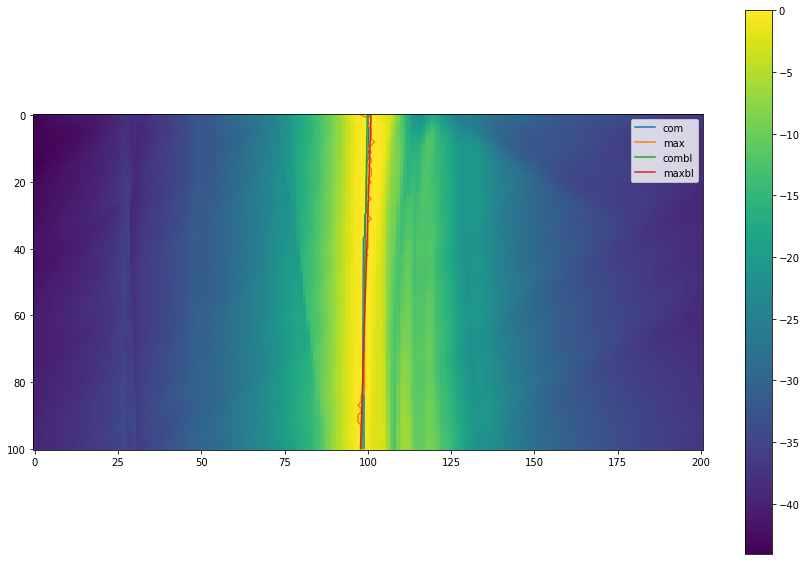

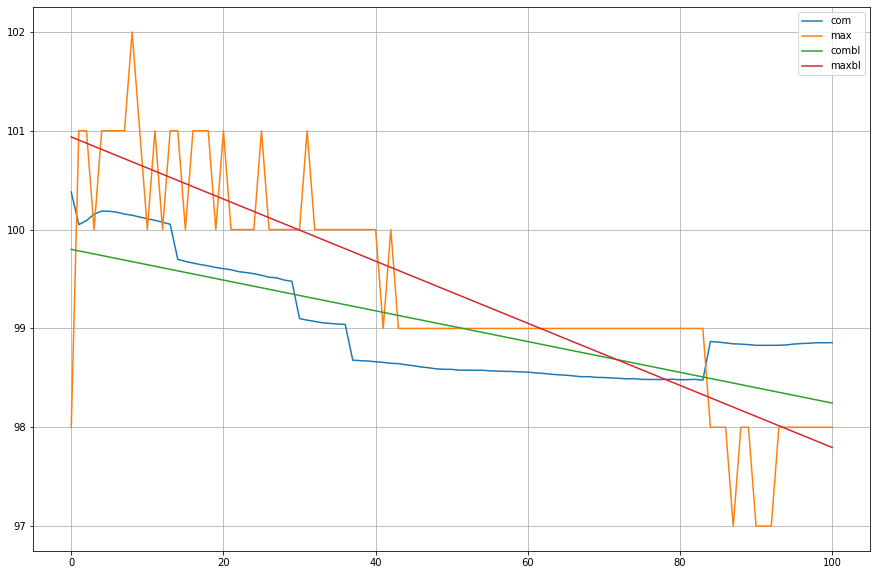

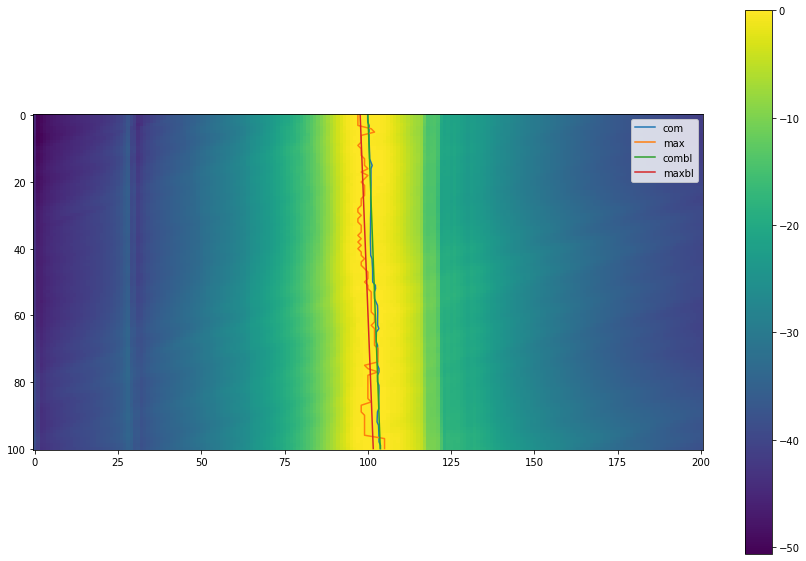

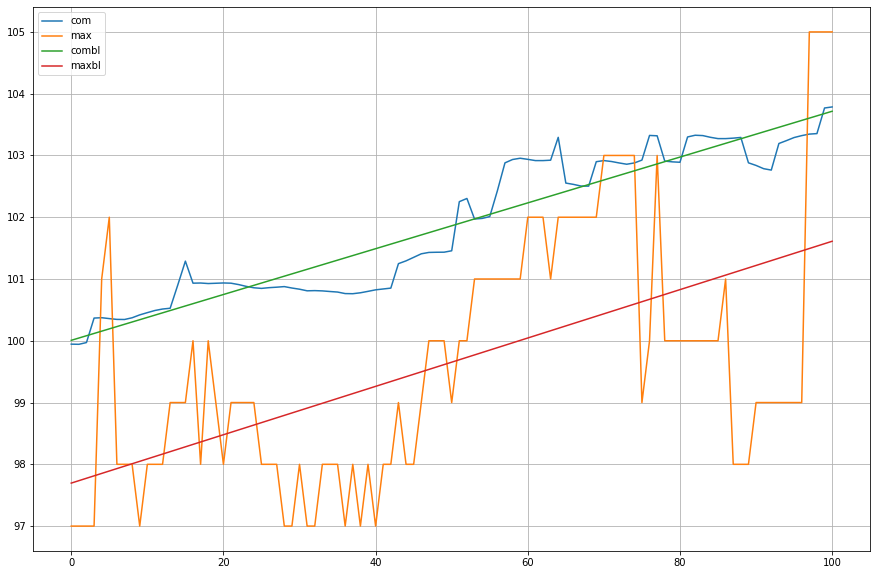

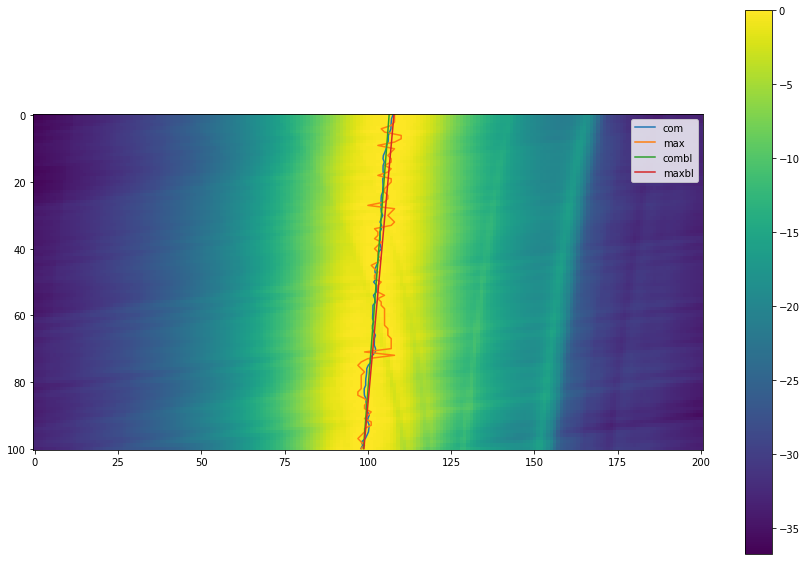

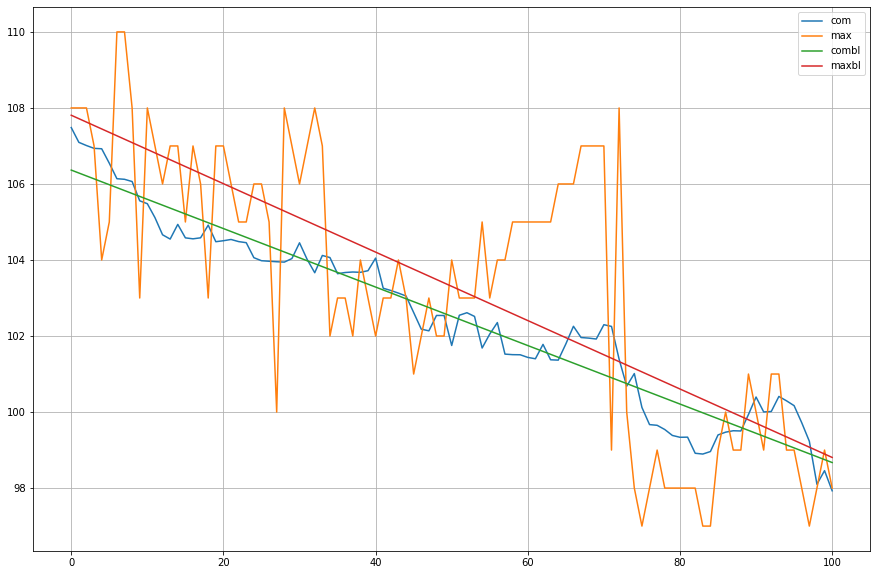

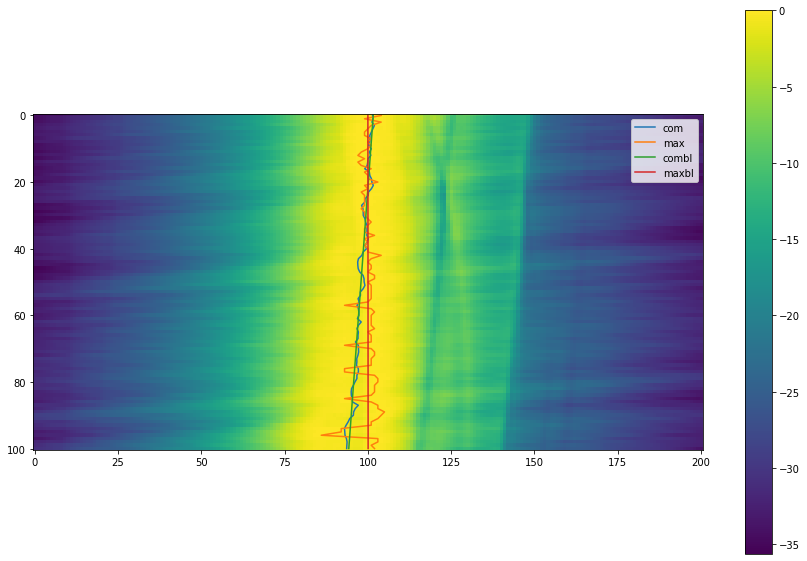

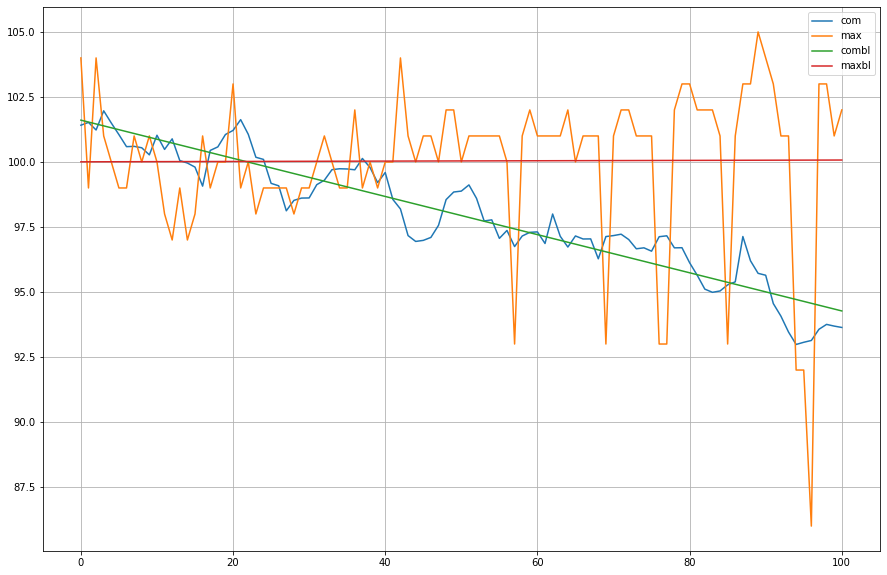

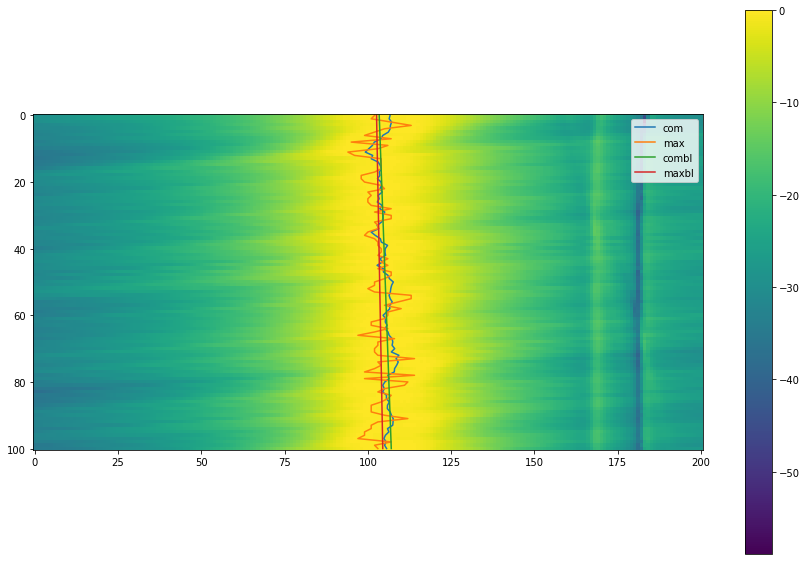

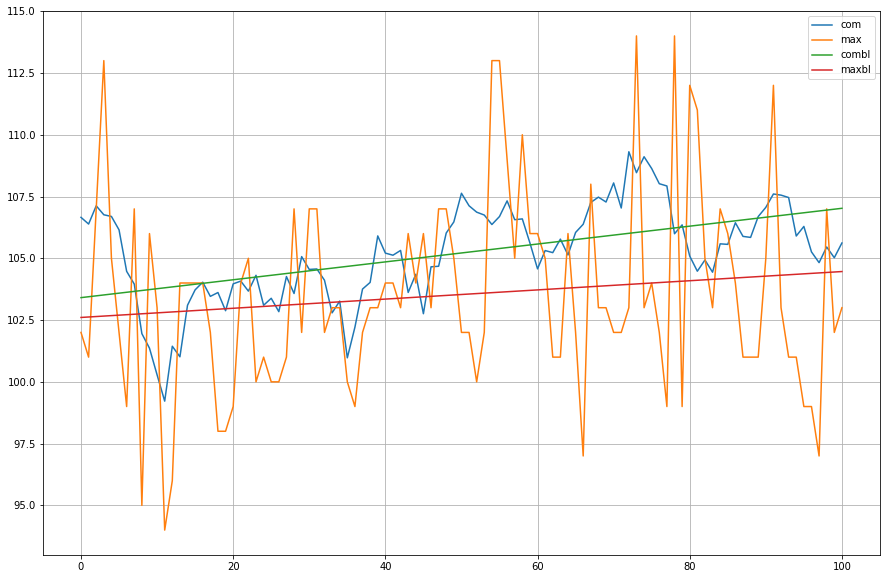

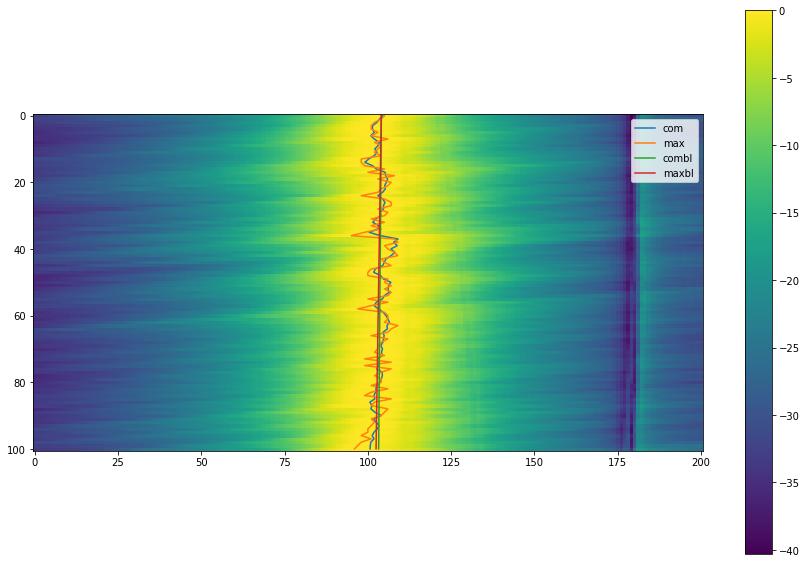

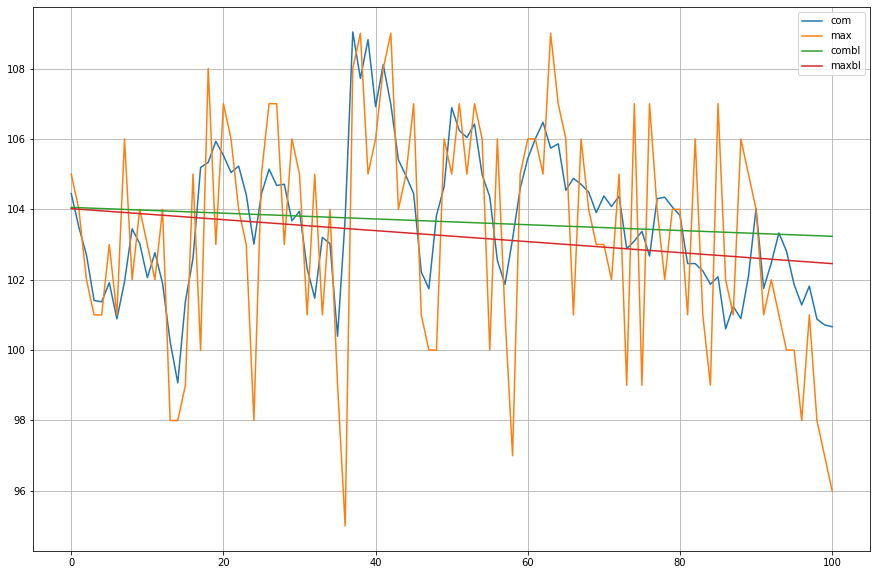

In [58]:

ftm = loadData('coarse_tuning_fine_measurements')
coarseData = loadData('coarse_filter_parameters')

print(ftm.keys())
def computeCenterOfMass(s21Mag):
    ns=s21Mag.shape[1]
    massPositionProduct=np.multiply(s21Mag,np.arange(ns))
    massPositionProductSum=np.sum(massPositionProduct, axis=1)
    centerOfMass = massPositionProductSum/np.sum(s21Mag,axis=1)
    return centerOfMass

def computeCenterOfMassLim(s21Mag, lim):
    rows, numSamp=s21Mag.shape
    centerOfMass=[]
    for r in range(rows):
        currentLine = s21Mag[r,:]
        valids = currentLine >= lim
        s21sel=currentLine[valids]
        idxSel=np.arange(numSamp)[valids]
        massPositionProduct=np.multiply(s21sel,idxSel)
        massPositionProductSum=np.sum(massPositionProduct)
        centerOfMass.append(massPositionProductSum/np.sum(s21sel))
    return np.array(centerOfMass)

def indexToFrequency(idx, fmap):
    rows, cols = fmap.shape
    iax = np.arange(cols)
    fs=[]
    for row in np.arange(rows):
        fs.append(np.interp(idx[row], iax, fmap[row,:]))
    return np.array(fs)

def analyzeFilterData(s21, freqMap, words):
    s21Mag=np.abs(s21)
    rows=s21Mag.shape[0]
    ya = np.arange(rows)
    
    peakValues = np.max(s21Mag, axis=1)
    s21Norm = s21Mag / peakValues[:,None]

    centerOfMass = computeCenterOfMassLim(s21Mag, 0.5)
    centerOfMassCoeff = np.polyfit(ya, centerOfMass, deg=1)
    centerOfMassFunc = np.poly1d(centerOfMassCoeff)
    
    #compute peak center
    peaks = np.argmax(s21Mag, axis=1)
    peaksCoeff = np.polyfit(ya, peaks, deg=1)
    peaksFunc = np.poly1d(peaksCoeff)
    
    plt.figure();
    plt.imshow(dB(s21Norm))
    plt.plot(centerOfMass.T, ya, label='com')
    plt.plot(peaks.T, ya, label='max')
    plt.plot(centerOfMassFunc(ya), ya, label='combl')
    plt.plot(peaksFunc(ya), ya, label='maxbl')
    plt.colorbar()
    plt.legend()
    plt.figure()
    plt.plot(ya, centerOfMass.T, label='com')
    plt.plot(ya, peaks.T, label='max')
    plt.plot(ya, centerOfMassFunc(ya), label='combl')
    plt.plot(ya, peaksFunc(ya), label='maxbl')
    plt.grid(True)
    plt.legend()


    centerOfMassFreqs = indexToFrequency(centerOfMass, freqMap)
    linCoeff = np.polyfit(centerOfMassFreqs, words, deg=1)
    k, m = linCoeff
    print("K %f [LSB/MHz] M %f [LSB]"%(k*1e6, m))
    return k, m

    
    
for a in range(6):
    baseKey='filter%d'%(a)
    s21=ftm[baseKey+'Map']
    freqMap = ftm[baseKey+'SpanMap']
    words = np.squeeze(ftm[baseKey+'TuningWords'])
    
    analyzeFilterData(s21, freqMap, words)


